# 06 — RL with Different Algorithms

This notebook trains and evaluates multiple RL algorithms (PPO, A2C, SAC, TD3) on the same microgrid environment.



## Imports and Paths

In [1]:
import os, sys
import pandas as pd

# Path for local package
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# # Microgrid sim imports
# from microgrid_sim.core import MicrogridGymEnv, MicrogridEnv
# from microgrid_sim.data import SyntheticDataBuilder
# from microgrid_sim.utils import plot_simulation, plot_reward_progress
# from microgrid_sim.components import PVGenerator, WindTurbine, FossilGenerator, GridIntertie, BatteryStorage, ResidentialLoad, FactoryLoad
# from microgrid_sim.control import RLController


# Import simulation components
from microgrid_sim.core.gym_wrapper import MicrogridGymEnv
from microgrid_sim.control.rl_controller import RLController
from microgrid_sim.data import SyntheticDataBuilder
from microgrid_sim.utils import plot_simulation, plot_reward_progress
from microgrid_sim.components.generators import PVGenerator, WindTurbine, FossilGenerator, GridIntertie, ReliabilityParams
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.components.loads import ResidentialLoad, FactoryLoad
from microgrid_sim.core.environment import MicrogridEnv
from microgrid_sim.control import RuleBasedEMS
from microgrid_sim.control.rules import BatteryRule, DieselRule, GridRule, TimeSchedule, RenewableDisconnectRule

# SB3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO, A2C, SAC, TD3

print("Imports OK")


Imports OK


## Global Configurations

In [2]:
# --- Global constants ---
NO_OF_EPISODES = 1000
TOTAL_HOURS    = 24 * 7   # 7 days of synthetic data per dataset
CONTROL_DT     = 60       # minutes per control decision
SIM_DT         = 60        # simulation step minutes
SEED           = 42

CONTROL_STEPS_PER_EP = (TOTAL_HOURS * 60) // CONTROL_DT  # 120 control steps/episode
TRAINING_TIMESTEPS   = CONTROL_STEPS_PER_EP * NO_OF_EPISODES

# Reward
UNUSED_POWER_COST = 3.5  # Cost per kWh of unused power
WASTED_POWER_COST = 1.5  # Cost per kWh of wasted power
REWARD_WEIGHTS={
    "cost": 5.0,
    "unmet": 10.0 * UNUSED_POWER_COST,
    "curtailment": 0.1 * WASTED_POWER_COST,
    "soc_deviation": 0.0,
}

# paths
MODEL_DIR   = "./models"
LOG_DIR     = "./logs/algos"
RESULTS_DIR = "./plots/06_rl_algos"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

USE_SAVED_MODELS = False
global_data = {
    "results": {},
    "envs": {},
    "models": {}
}

print("Config OK")
print(f"Control steps/episode: {CONTROL_STEPS_PER_EP}")
print(f"Total training timesteps: {TRAINING_TIMESTEPS}")


Config OK
Control steps/episode: 168
Total training timesteps: 168000


## Environment Setup

In [3]:
def setup_data_builder(seed: int) -> SyntheticDataBuilder:
    builder = SyntheticDataBuilder(
        total_hours=TOTAL_HOURS,
        sim_dt_minutes=SIM_DT,
        seed=seed
    )
    # Names must match env components below
    builder.add_pv("pv", peak_irr=900)
    builder.add_wind("wind", mean_speed=6.0)
    builder.add_grid_prices("grid")
    return builder


def setup_microgrid_env(seed: int) -> MicrogridEnv:
    env = MicrogridEnv(
        simulation_hours=TOTAL_HOURS,
        control_interval_minutes=CONTROL_DT,
        sim_dt_minutes=SIM_DT
    )

    pv_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.05,
        minor_prob_fraction=0.6,
        minor_derate=0.5,
        mttr_minor_hours=2,
        mttr_major_hours=8,
        maint_cost_per_hour=5.0,
        exo_keys=("irradiance_Wm2",),  # hazard rises with irradiance above shift
        exo_weight=0.002,
        exo_shift=800.0,
    )

    pv = PVGenerator(
        "pv",
        capacity_kw=350.0,
        time_step_minutes=SIM_DT,
        operational_cost_per_kwh=0.02,
        reliability=pv_rel,
        )

    wind_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.08,
        minor_prob_fraction=0.7,
        minor_derate=0.6,
        mttr_minor_hours=6,
        mttr_major_hours=16,
        maint_cost_per_hour=7.0,
        exo_keys=("wind_speed_ms",),  # hazard rises with wind speed above shift
        exo_weight=0.01,
        exo_shift=8.0,
    )

    wind = WindTurbine(
        "wind", rated_kw=200.0,
        time_step_minutes=SIM_DT,
        operational_cost_per_kwh=0.027,
        reliability=wind_rel,
        )

    diesel_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.05,
        minor_prob_fraction=0.5,
        minor_derate=0.7,
        mttr_minor_hours=4,
        mttr_major_hours=12,
        maint_cost_per_hour=10.0,
        exo_keys=(),
        exo_weight=0.0,
        exo_shift=0.0,
    )

    diesel = FossilGenerator(
        "diesel", p_min_kw=0.0, p_max_kw=200.0,
        time_step_minutes=SIM_DT,
        fuel_cost_per_kwh=0.45, # ~1.66 SAR/L × 0.27 L/kWh
        operational_cost_per_hour=1.0,
        reliability=diesel_rel,
        )

    house = ResidentialLoad("house", base_kw=200.0, noise_std=0.15, seed=seed)

    factory = FactoryLoad("factory", base_kw=450.0, noise_std=0.5, seed=seed)

    bat_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.01,
        minor_prob_fraction=0.9,
        minor_derate=0.95,
        mttr_minor_hours=1,
        mttr_major_hours=4,
        maint_cost_per_hour=2.0,
        exo_keys=(),
        exo_weight=0.0,
        exo_shift=0.0,
    )

    BAT_CAPACITY_KW = 411.0
    bat = BatteryStorage(
        "bat",
        capacity_kwh=BAT_CAPACITY_KW * 4,
        time_step_minutes=SIM_DT,
        max_charge_kw=BAT_CAPACITY_KW/4,
        max_discharge_kw=BAT_CAPACITY_KW/4,
        degradation_cost_per_kwh=0.086,
        reliability=bat_rel,
    )

    grid_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.01,
        minor_prob_fraction=0.8,
        minor_derate=0.9,
        mttr_minor_hours=2,
        mttr_major_hours=8,
        maint_cost_per_hour=0.0,
        exo_keys=(),
        exo_weight=0.0,
        exo_shift=0.0,
    )

    grid = GridIntertie(
        "grid", time_step_minutes=SIM_DT,
        import_limit_kw=1000.0,
        export_limit_kw=1000.0,
        price_export_per_kwh=0.20,
        price_import_per_kwh=0.20,
        reliability=grid_rel,
    )

    # Add all components
    for c in [pv, wind, diesel, house, factory, bat]:
        env.add_component(c)

    env.add_component(grid, is_grid=True)

    return env


def build_wrapped_env(seed: int, log_csv_path: str):
    """
    Returns: (train_eval_env_flat_and_monitored, orig_dict_env_reference)
    - Flattened Box action env for SB3
    - Monitor wrapper logs reward to CSV for our plots
    - Keep a reference to the original dict env (to get DataFrame results)
    """
    base_env = setup_microgrid_env(seed)
    data_builder = setup_data_builder(seed)

    gym_env_dict = MicrogridGymEnv(
        microgrid_env=base_env,
        data_builder=data_builder,
        reward_weights=REWARD_WEIGHTS,
    )
    gym_env_flat = gym_env_dict.create_flattened_env()
    env_mon = Monitor(gym_env_flat, filename=log_csv_path)

    return env_mon, gym_env_dict


In [4]:
def run_full_episode(env_flat, policy, seed=SEED):
    """
    Runs one full episode with a trained policy on a flattened env.
    Returns (df_results, total_reward, steps).
    """
    obs, info = env_flat.reset(seed=seed)
    total_reward = 0.0
    done = False
    steps = 0
    while not done:
        action, _ = policy.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env_flat.step(action)
        total_reward += reward
        steps += 1
        done = terminated or truncated

    df = env_flat.unwrapped.env.get_results(as_dataframe=True)
    return df, float(total_reward), steps


def summarize_results(df, sim_dt_minutes=SIM_DT):
    dt_hours = sim_dt_minutes / 60.0
    total_cost = float(df["total_cashflow"].sum() if "total_cashflow" in df.columns else 0.0)
    unmet_kwh = float(df["unmet_load_kw"].sum() * dt_hours if "unmet_load_kw" in df.columns else 0.0)
    curtailed_kwh = float(df["curtailed_gen_kw"].sum() * dt_hours if "curtailed_gen_kw" in df.columns else 0.0)
    return {"Total Cost ($)": total_cost, "Unmet Energy (kWh)": unmet_kwh, "Curtailed Energy (kWh)": curtailed_kwh}


In [5]:
def manage_training(AlgoClass, algo_name, env_train, total_timesteps, **kwargs):
    """Initializes and trains/loads the controller, returning the policy and model path."""

    model_path = os.path.join(MODEL_DIR, f"{algo_name}_microgrid")
    model_file = f"{model_path}.zip"
    policy = None

    # 1. Attempt to Load
    if USE_SAVED_MODELS and os.path.exists(model_file):
        try:
            print(f"\n--- {algo_name}: Loading existing model ---")
            policy = AlgoClass.load(model_path, env=env_train, algo=algo_name)
        except Exception as e:
            print(f"Failed to load {algo_name}: {e}. Training new model.")
            policy = None

    # 2. Train if Loading Failed or Not Allowed
    if policy is None:
        print(f"\n--- {algo_name}: Building and training new model ---")

        rl_controller = RLController(
            algo=algo_name, env=env_train, **kwargs
        )

        rl_controller.train(total_timesteps=total_timesteps, log_dir=LOG_DIR)
        print(f"{algo_name} training complete. Saving model...")

        rl_controller.save(model_path)
        policy = rl_controller.model
        print(f"{algo_name} trained and saved.")

    return policy, model_path

# Setup all environments

In [6]:
# Global setup of environments (run once)
ppo_env_train_vec, _ = build_wrapped_env(seed=SEED, log_csv_path=os.path.join(LOG_DIR, "PPO_monitor.csv"))
a2c_env_train_vec, _ = build_wrapped_env(seed=SEED, log_csv_path=os.path.join(LOG_DIR, "A2C_monitor.csv"))
sac_env_train_vec, _ = build_wrapped_env(seed=SEED, log_csv_path=os.path.join(LOG_DIR, "SAC_monitor.csv"))
td3_env_train_vec, _ = build_wrapped_env(seed=SEED, log_csv_path=os.path.join(LOG_DIR, "TD3_monitor.csv"))

ppo_env_test_vec, _ = build_wrapped_env(seed=SEED + 1, log_csv_path=os.path.join(LOG_DIR, "PPO_test_monitor.csv"))
a2c_env_test_vec, _ = build_wrapped_env(seed=SEED + 1, log_csv_path=os.path.join(LOG_DIR, "A2C_test_monitor.csv"))
sac_env_test_vec, _ = build_wrapped_env(seed=SEED + 1, log_csv_path=os.path.join(LOG_DIR, "SAC_test_monitor.csv"))
td3_env_test_vec, _ = build_wrapped_env(seed=SEED + 1, log_csv_path=os.path.join(LOG_DIR, "TD3_test_monitor.csv"))

print("Environments for training and testing set up.")

Environments for training and testing set up.


# PPO

## Train PPO

In [7]:
ppo_policy, ppo_model_path = manage_training(PPO, "PPO", ppo_env_train_vec, TRAINING_TIMESTEPS)


--- PPO: Building and training new model ---


Output()

PPO training complete. Saving model...
PPO trained and saved.


## PPO reward progression plot

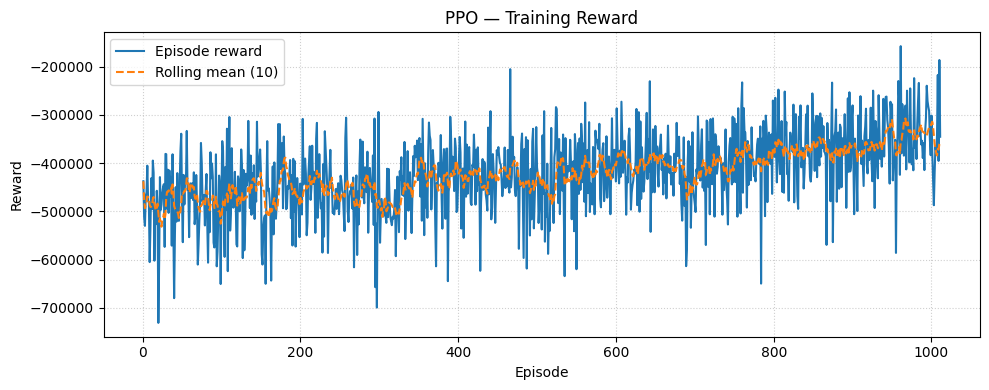

In [8]:
ppo_log_csv = os.path.join(LOG_DIR, "PPO_monitor.csv")
_ = plot_reward_progress(
    monitor_csv_path=ppo_log_csv,
    title="PPO — Training Reward",
    out_path=os.path.join(RESULTS_DIR, "ppo_reward_progress.png"),
    rolling=10
)

## PPO evaluation & plots

PPO reward: -26596.03
PPO metrics: {'Total Cost ($)': -5319.206532187158, 'Unmet Energy (kWh)': 0.0, 'Curtailed Energy (kWh)': 0.0}


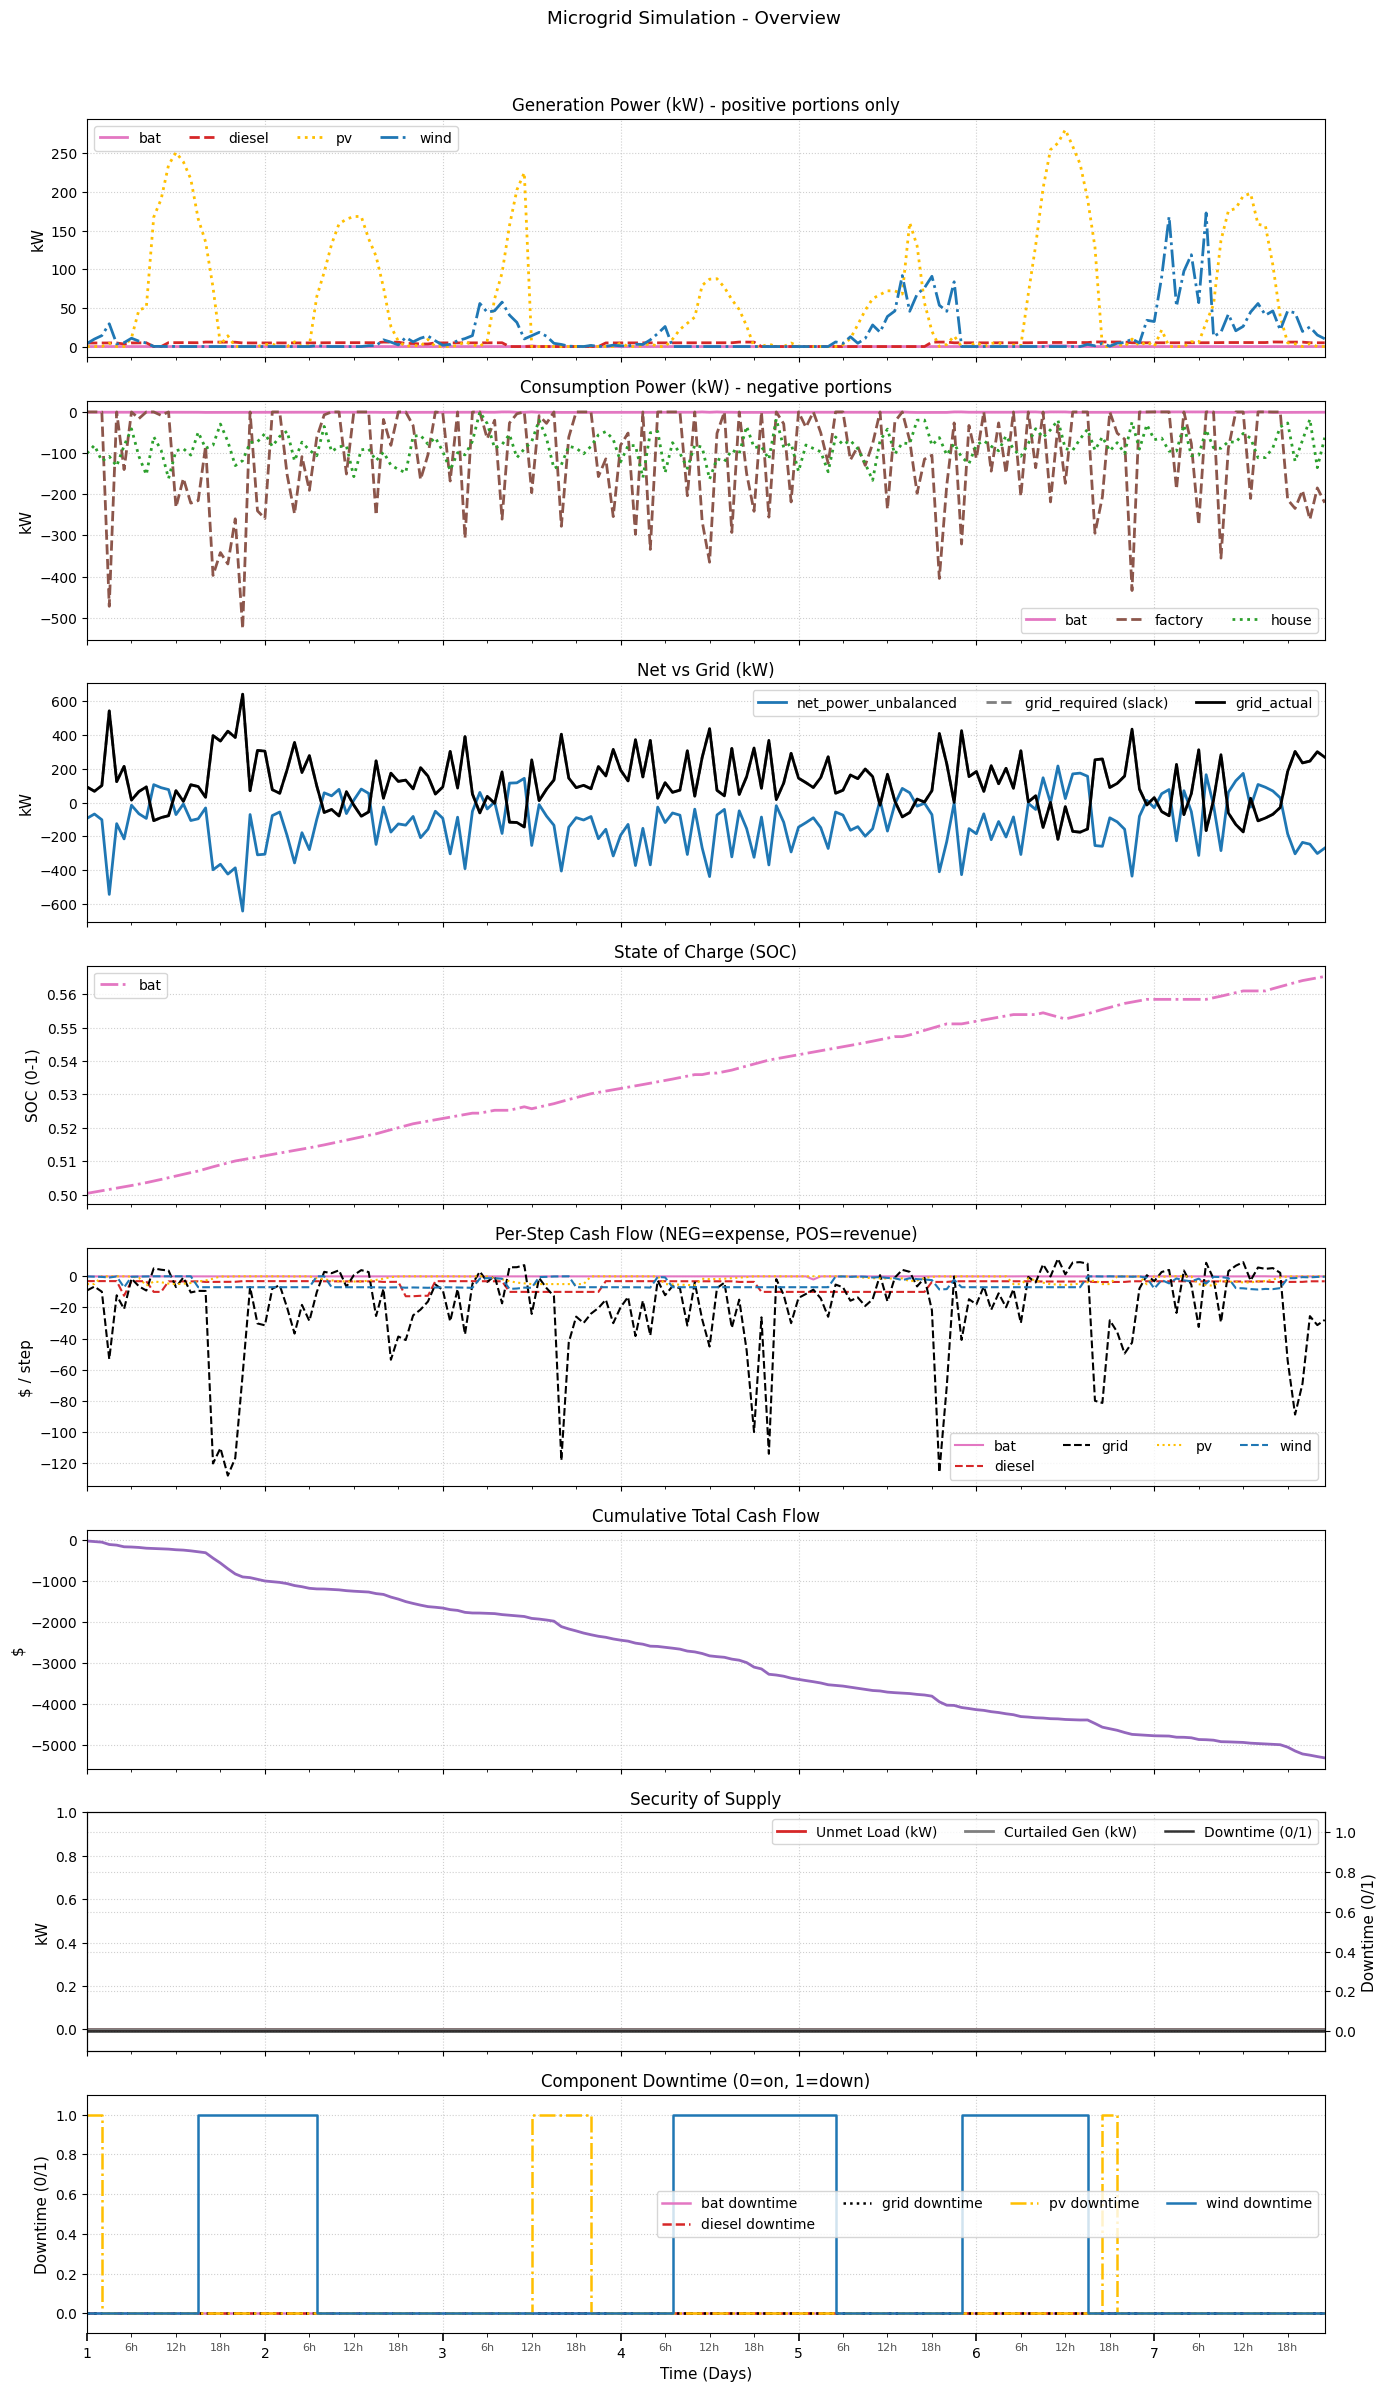

In [9]:
df_ppo, ppo_reward, ppo_steps = run_full_episode(ppo_env_test_vec, ppo_policy, seed=SEED+1)
ppo_metrics = summarize_results(df_ppo)
global_data["results"]["PPO"] = {**ppo_metrics, "Test Reward": ppo_reward}

print("PPO reward:", f"{ppo_reward:.2f}")
print("PPO metrics:", ppo_metrics)

_ = plot_simulation(
    df_ppo, sim_dt_minutes=SIM_DT, sim_name="06-PPO", save=True, base_dir=RESULTS_DIR
)

# A2C

## Train A2C

In [10]:
a2c_policy, a2c_model_path = manage_training(A2C, "A2C", a2c_env_train_vec, TRAINING_TIMESTEPS)

Output()


--- A2C: Building and training new model ---


A2C training complete. Saving model...
A2C trained and saved.


## A2C reward progression plot

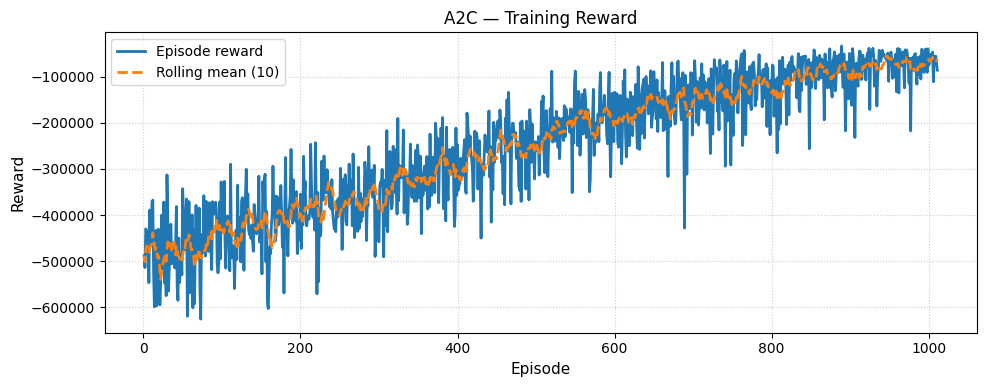

In [11]:
a2c_log_csv = os.path.join(LOG_DIR, "A2C_monitor.csv")
_ = plot_reward_progress(
    monitor_csv_path=a2c_log_csv,
    title="A2C — Training Reward",
    out_path=os.path.join(RESULTS_DIR, "a2c_reward_progress.png"),
    rolling=10
)


## A2C evaluation & plots

A2C reward: -37349.71
A2C metrics: {'Total Cost ($)': -7469.941259954461, 'Unmet Energy (kWh)': 0.0, 'Curtailed Energy (kWh)': 0.0}


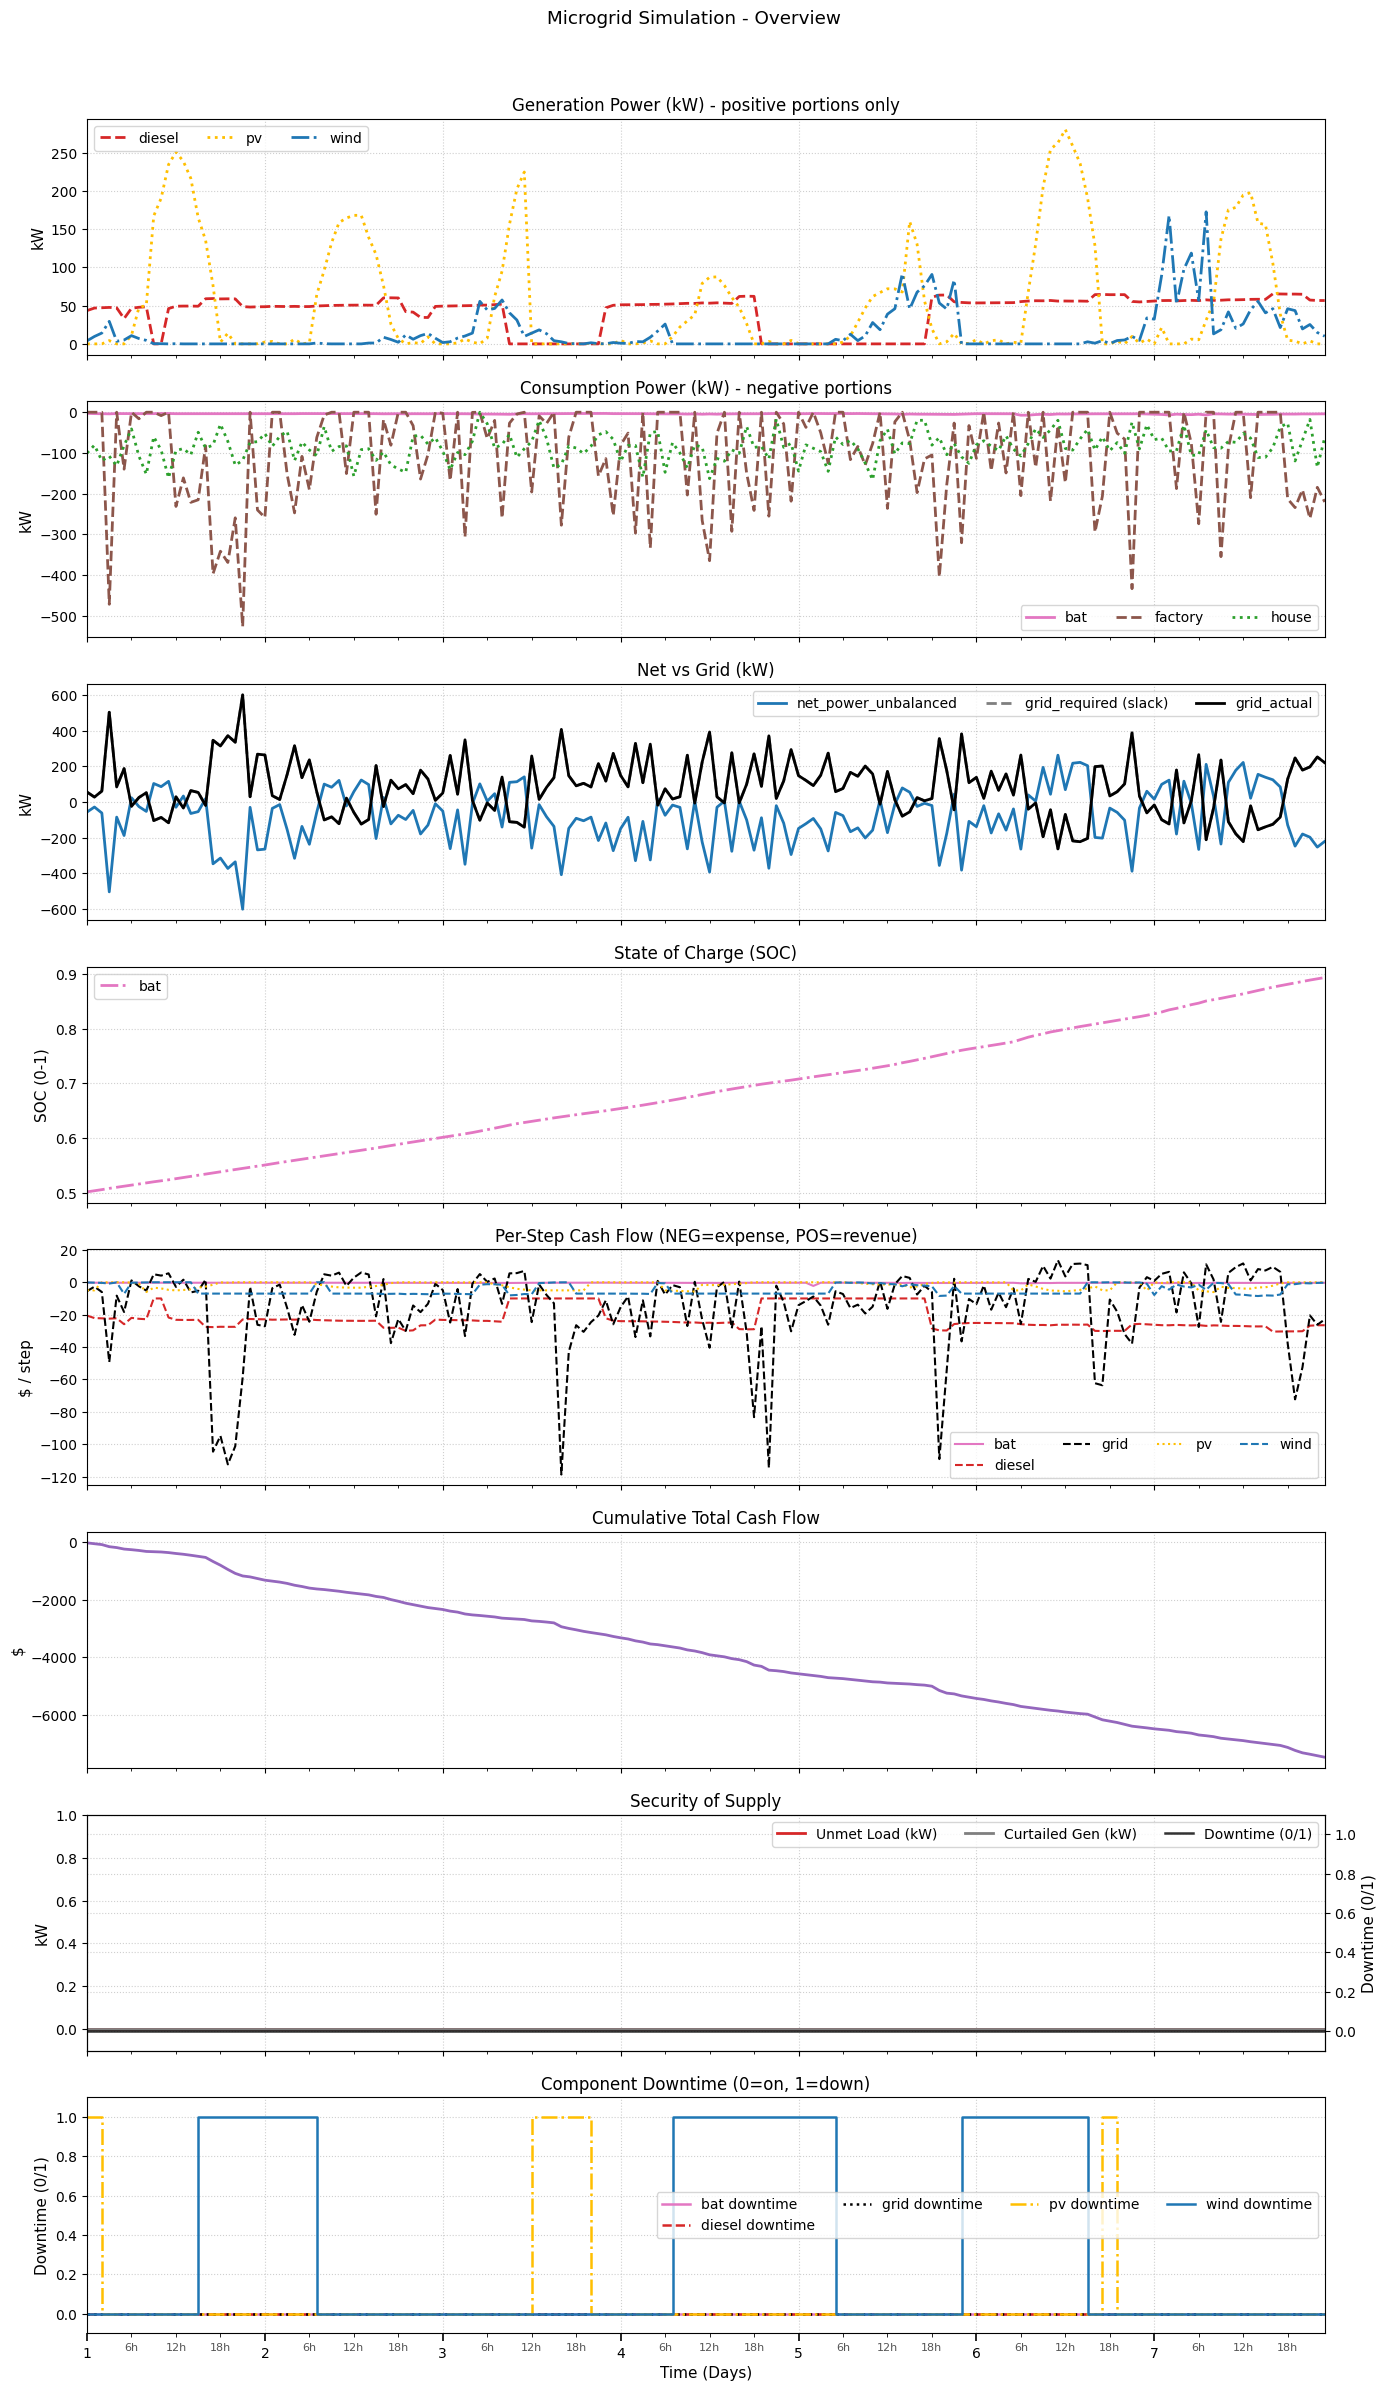

In [12]:
df_a2c, a2c_reward, a2c_steps = run_full_episode(a2c_env_test_vec, a2c_policy, seed=SEED+1)
a2c_metrics = summarize_results(df_a2c)
global_data["results"]["A2C"] = {**a2c_metrics, "Test Reward": a2c_reward}

print("A2C reward:", f"{a2c_reward:.2f}")
print("A2C metrics:", a2c_metrics)

_ = plot_simulation(
    df_a2c, sim_dt_minutes=SIM_DT, sim_name="06-A2C", save=True, base_dir=RESULTS_DIR
)


# SAC

## Train SAC

In [13]:
sac_policy, sac_model_path = manage_training(SAC, "SAC", sac_env_train_vec, TRAINING_TIMESTEPS)

Output()

SAC training complete. Saving model...
SAC trained and saved.


## SAC reward progression plot

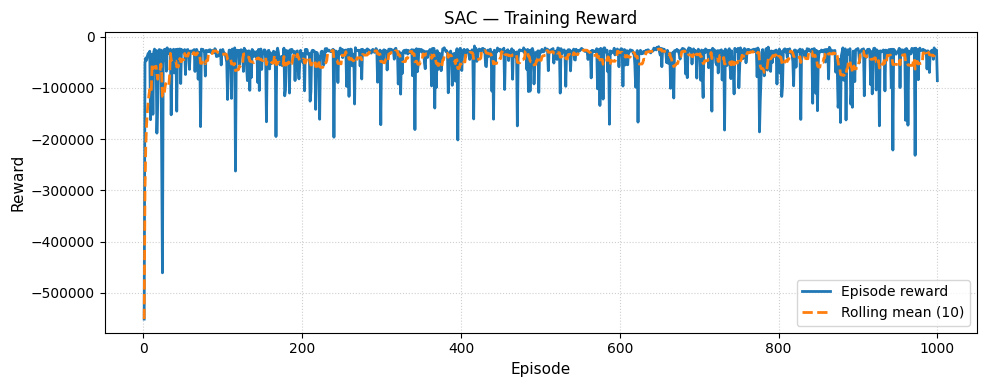

In [14]:
sac_log_csv = os.path.join(LOG_DIR, "SAC_monitor.csv")
_ = plot_reward_progress(
    monitor_csv_path=sac_log_csv,
    title="SAC — Training Reward",
    out_path=os.path.join(RESULTS_DIR, "sac_reward_progress.png"),
    rolling=10
);


## SAC evaluation & plots

SAC reward: -25085.12
SAC metrics: {'Total Cost ($)': -5017.02329564219, 'Unmet Energy (kWh)': 0.0, 'Curtailed Energy (kWh)': 0.0}


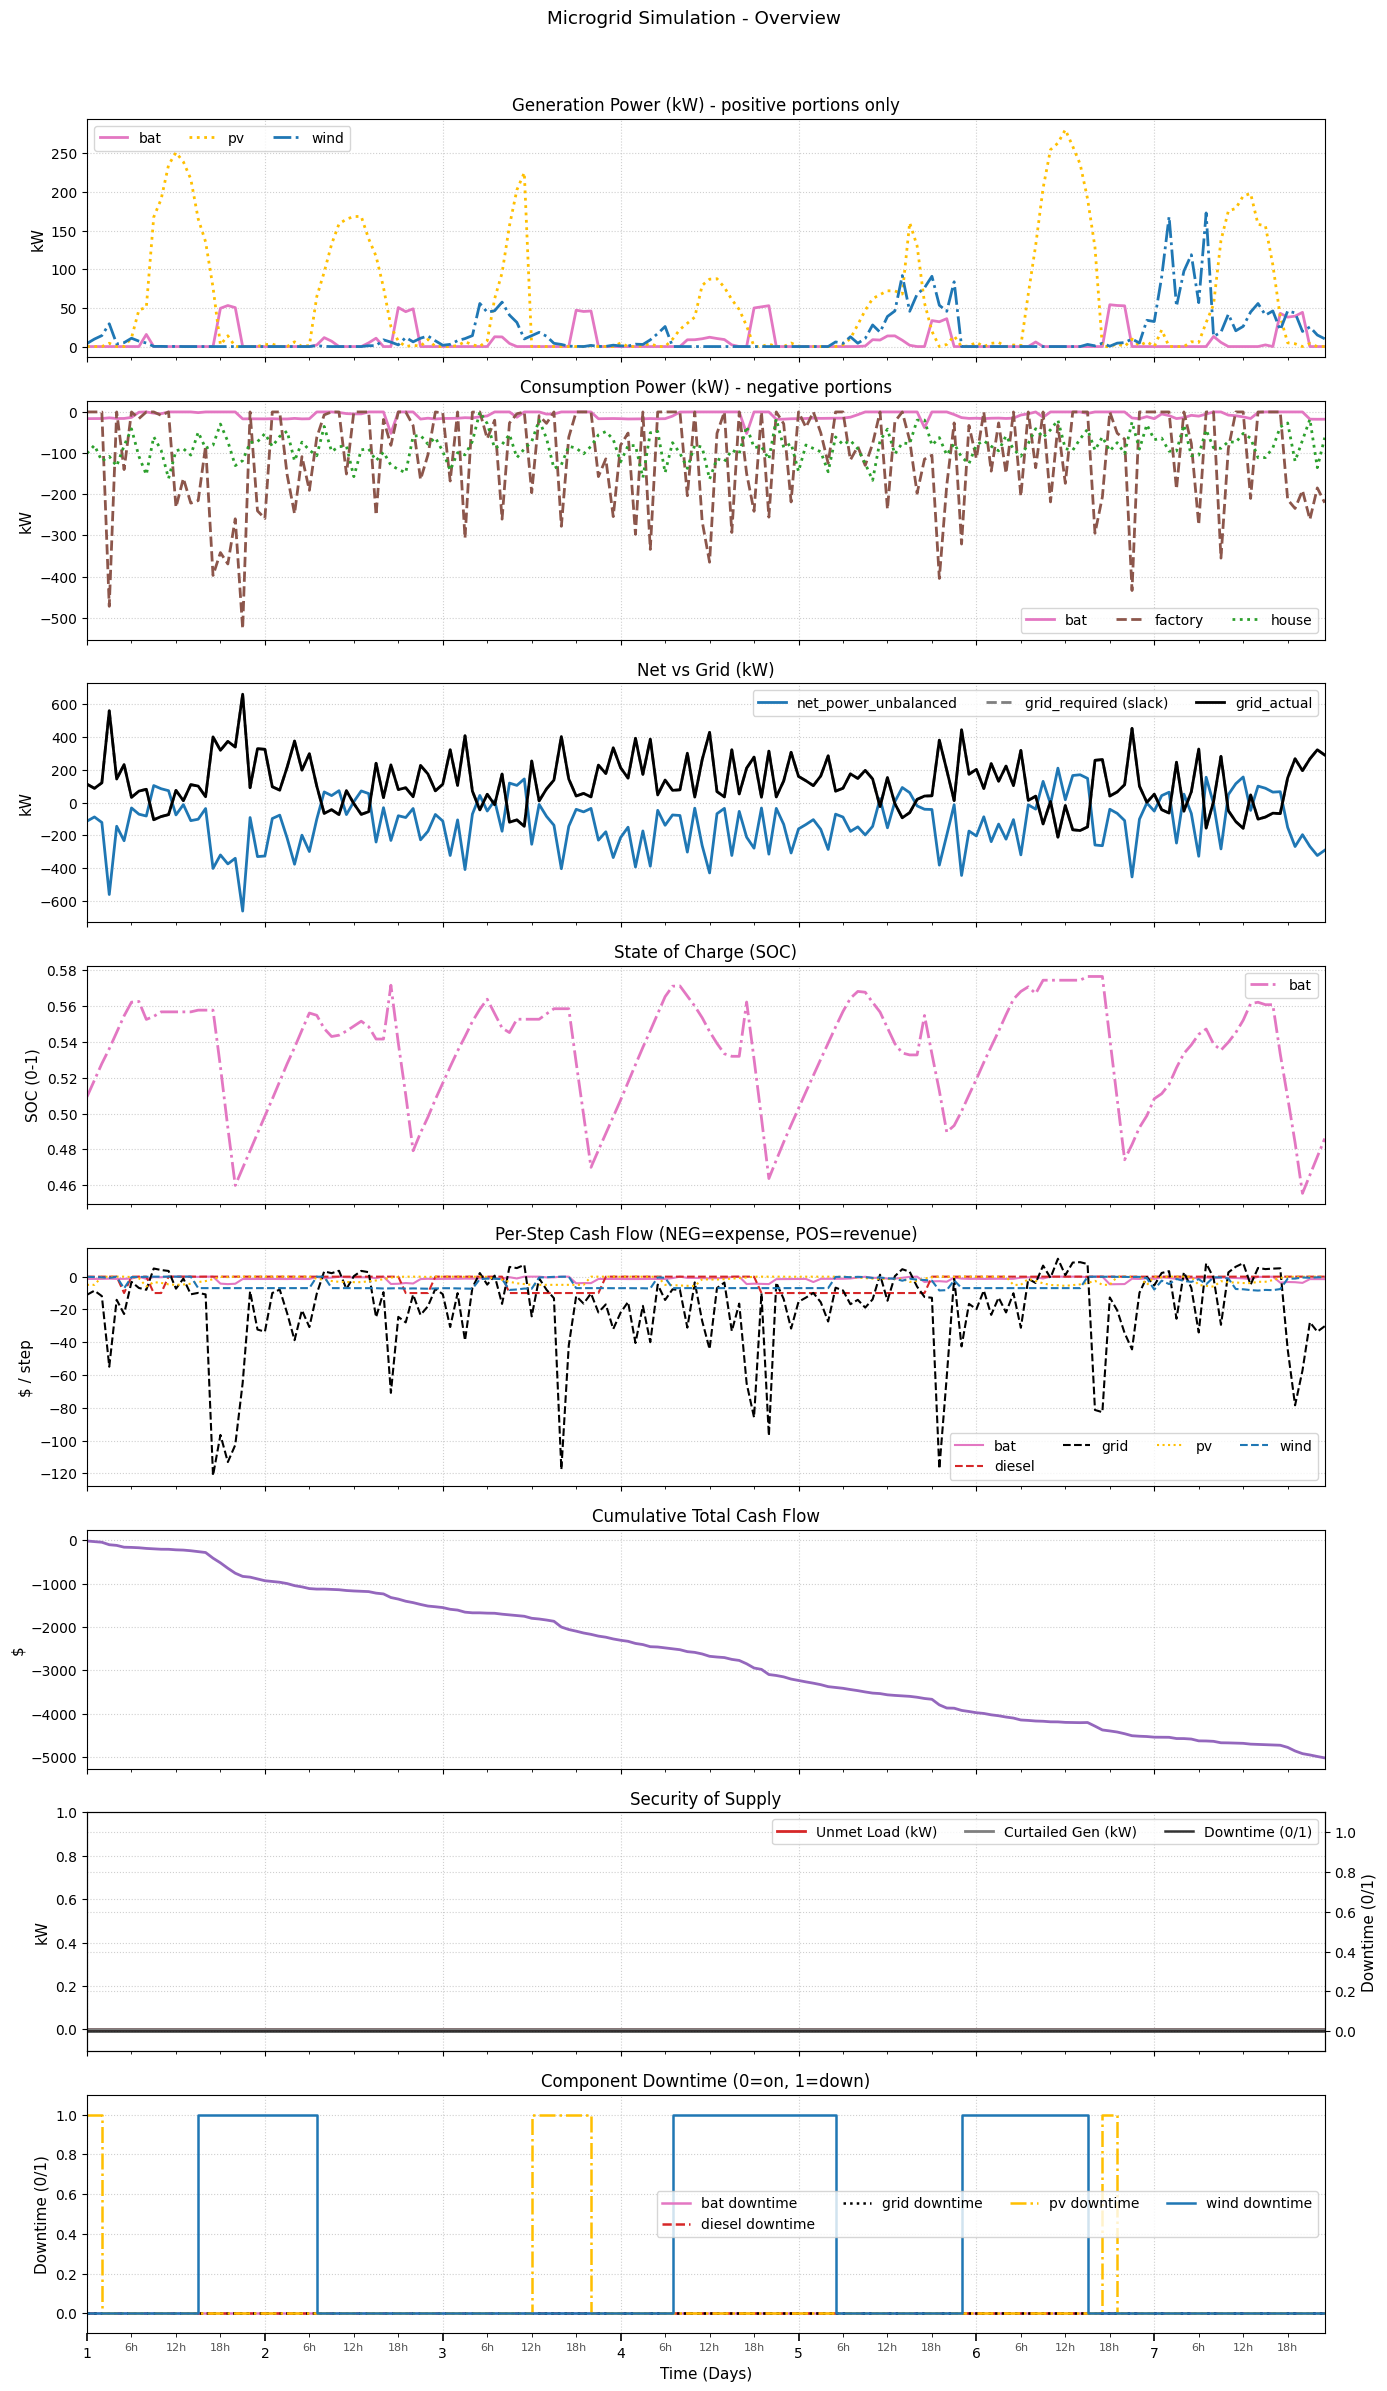

In [15]:
df_sac, sac_reward, sac_steps = run_full_episode(sac_env_test_vec, sac_policy, seed=SEED+1)
sac_metrics = summarize_results(df_sac)
global_data["results"]["SAC"] = {**sac_metrics, "Test Reward": sac_reward}

print("SAC reward:", f"{sac_reward:.2f}")
print("SAC metrics:", sac_metrics)

_ = plot_simulation(
    df_sac, sim_dt_minutes=SIM_DT, sim_name="06-SAC", save=True, base_dir=RESULTS_DIR
)


# TD3

## Train TD3

In [16]:
td3_policy, td3_model_path = manage_training(TD3, "TD3", td3_env_train_vec, TRAINING_TIMESTEPS)

Output()


--- TD3: Building and training new model ---


TD3 training complete. Saving model...
TD3 trained and saved.


## TD3 reward progression plot

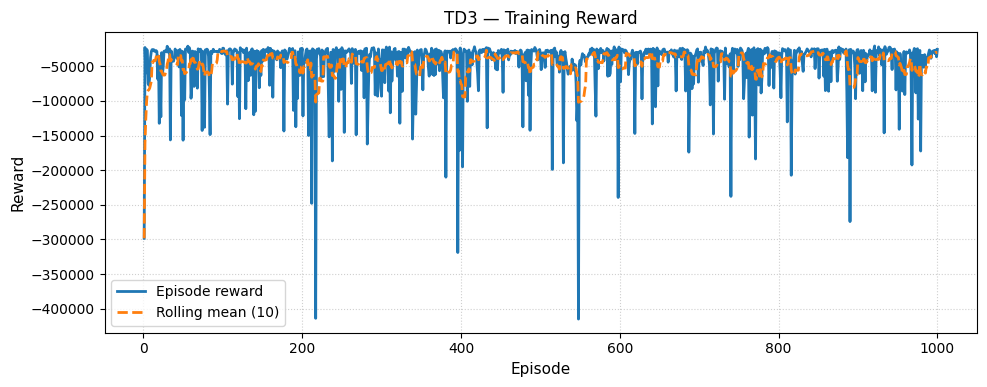

In [17]:
td3_log_csv = os.path.join(LOG_DIR, "TD3_monitor.csv")
_ = plot_reward_progress(
    monitor_csv_path=td3_log_csv,
    title="TD3 — Training Reward",
    out_path=os.path.join(RESULTS_DIR, "td3_reward_progress.png"),
    rolling=10
);


## TD3 evaluation & plots

TD3 reward: -26064.41
TD3 metrics: {'Total Cost ($)': -5212.881359924311, 'Unmet Energy (kWh)': 0.0, 'Curtailed Energy (kWh)': 0.0}


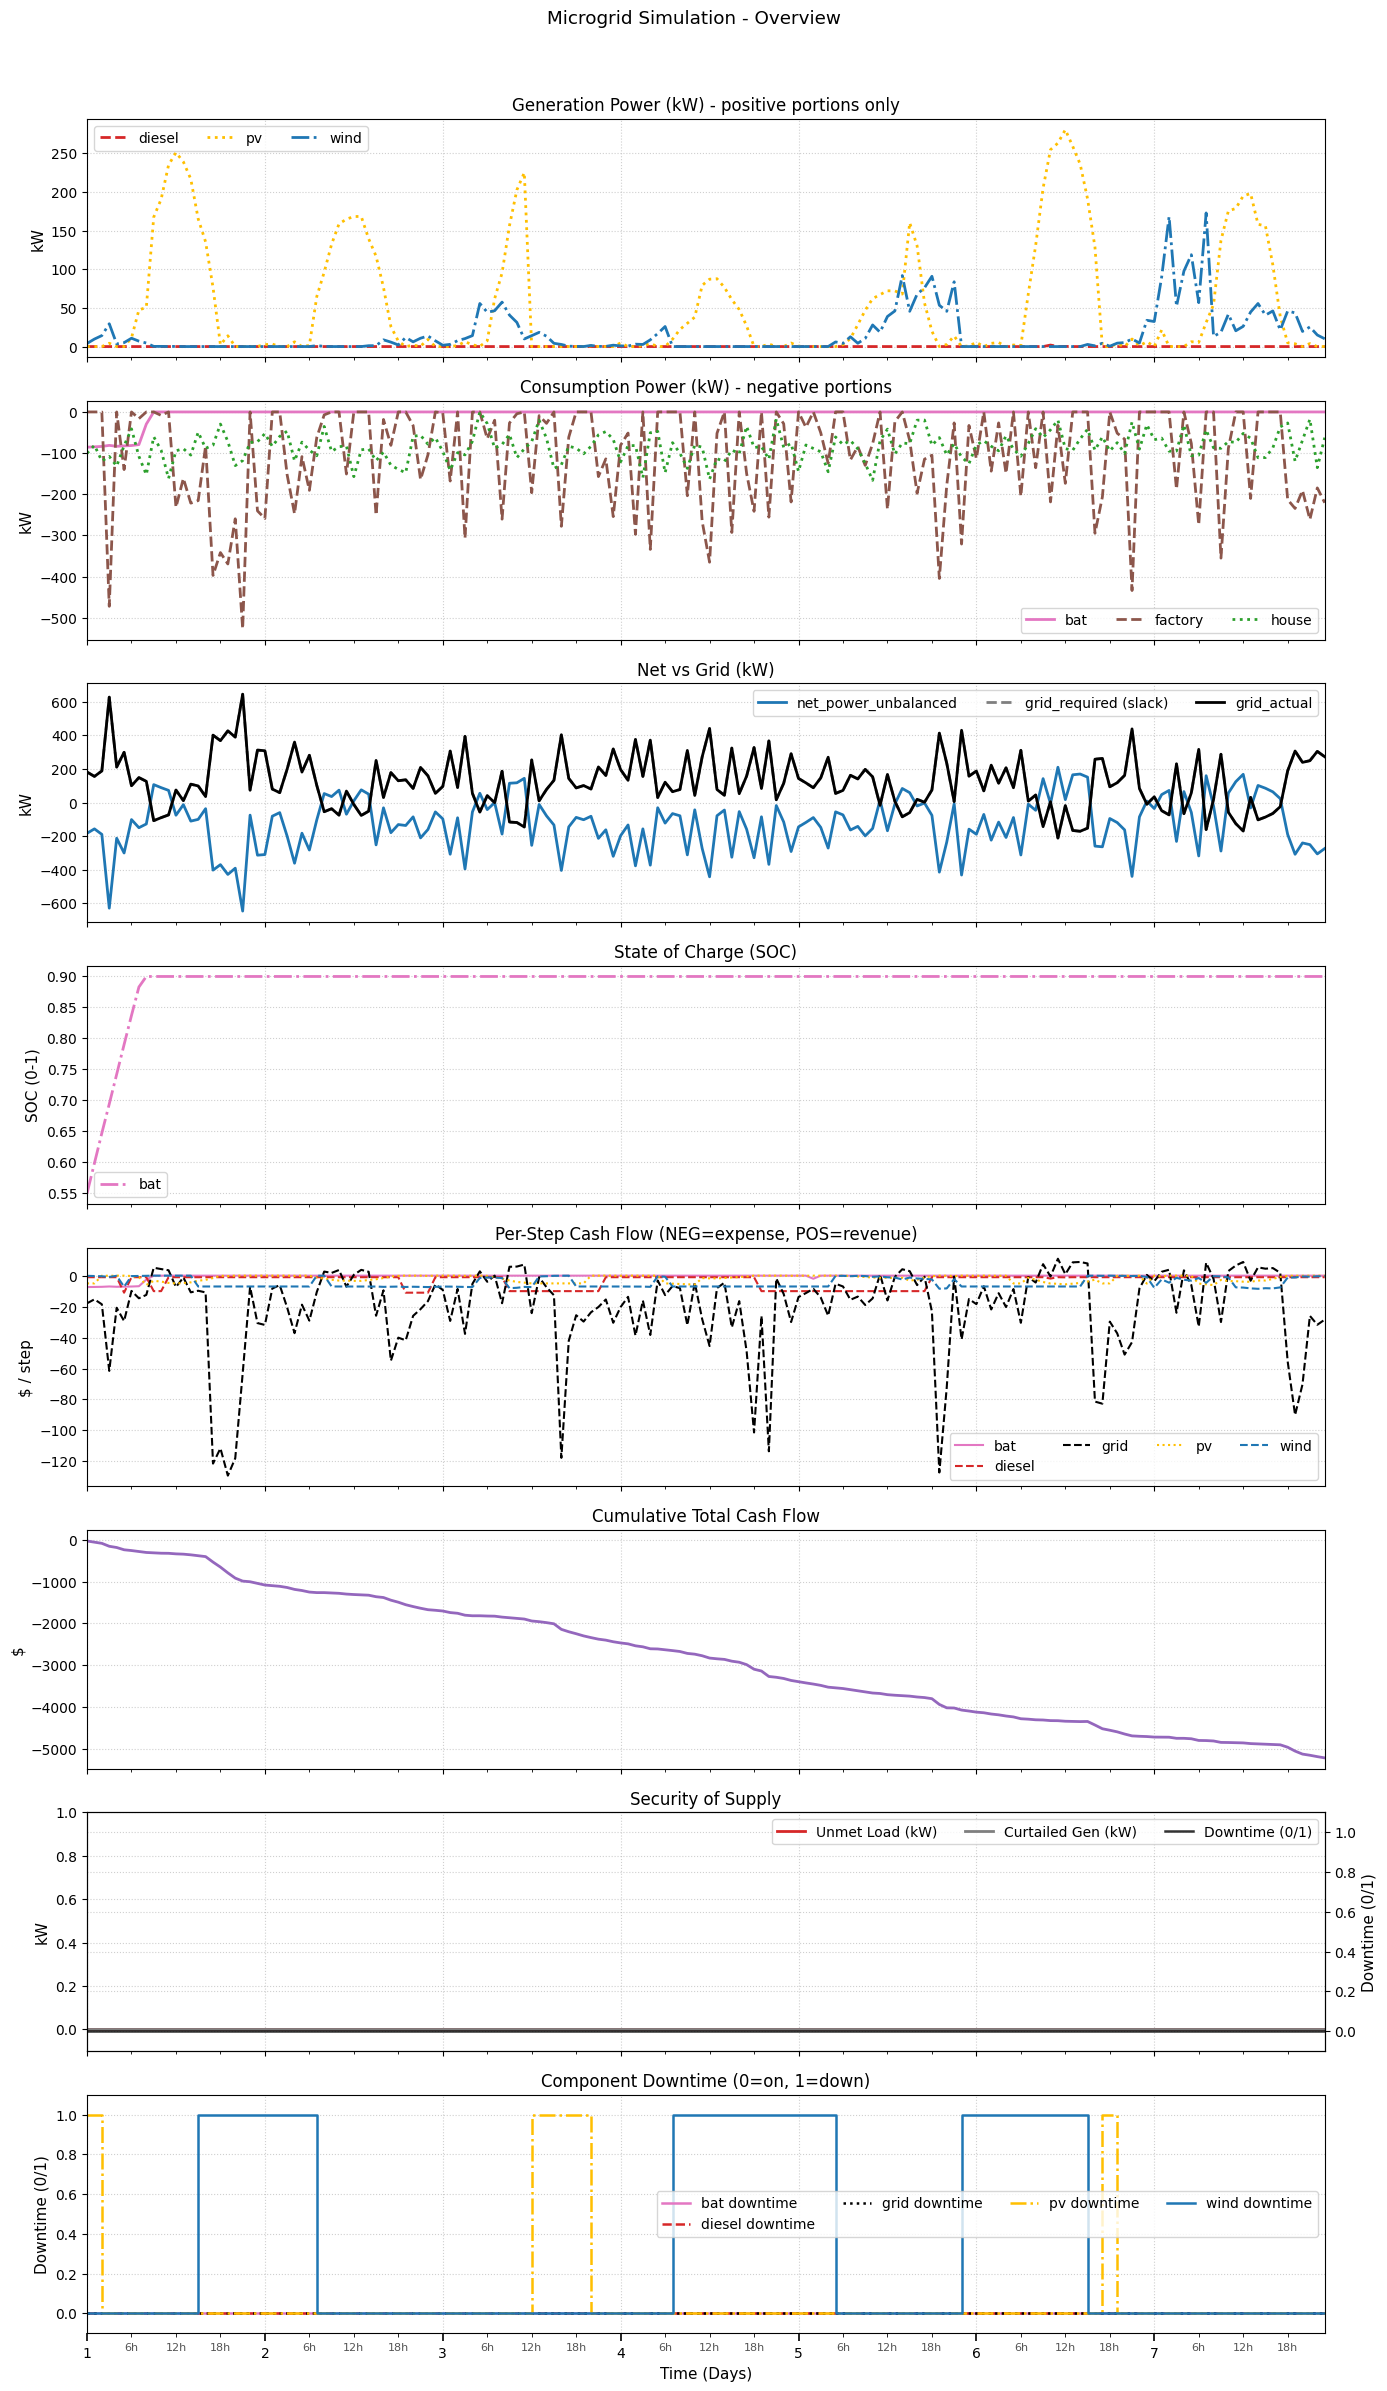

In [18]:
df_td3, td3_reward, td3_steps = run_full_episode(td3_env_test_vec, td3_policy, seed=SEED+1)
td3_metrics = summarize_results(df_td3)
global_data["results"]["TD3"] = {**td3_metrics, "Test Reward": td3_reward}

print("TD3 reward:", f"{td3_reward:.2f}")
print("TD3 metrics:", td3_metrics)

_ = plot_simulation(
    df_td3, sim_dt_minutes=SIM_DT, sim_name="06-TD3", save=True, base_dir=RESULTS_DIR
)

# Random Policy Baseline

## Random policy (for context)

Random steps: 168
Random reward: -580054.98
Random metrics: {'Total Cost ($)': -5365.849202699729, 'Unmet Energy (kWh)': 15798.156408382521, 'Curtailed Energy (kWh)': 1935.050839575495}


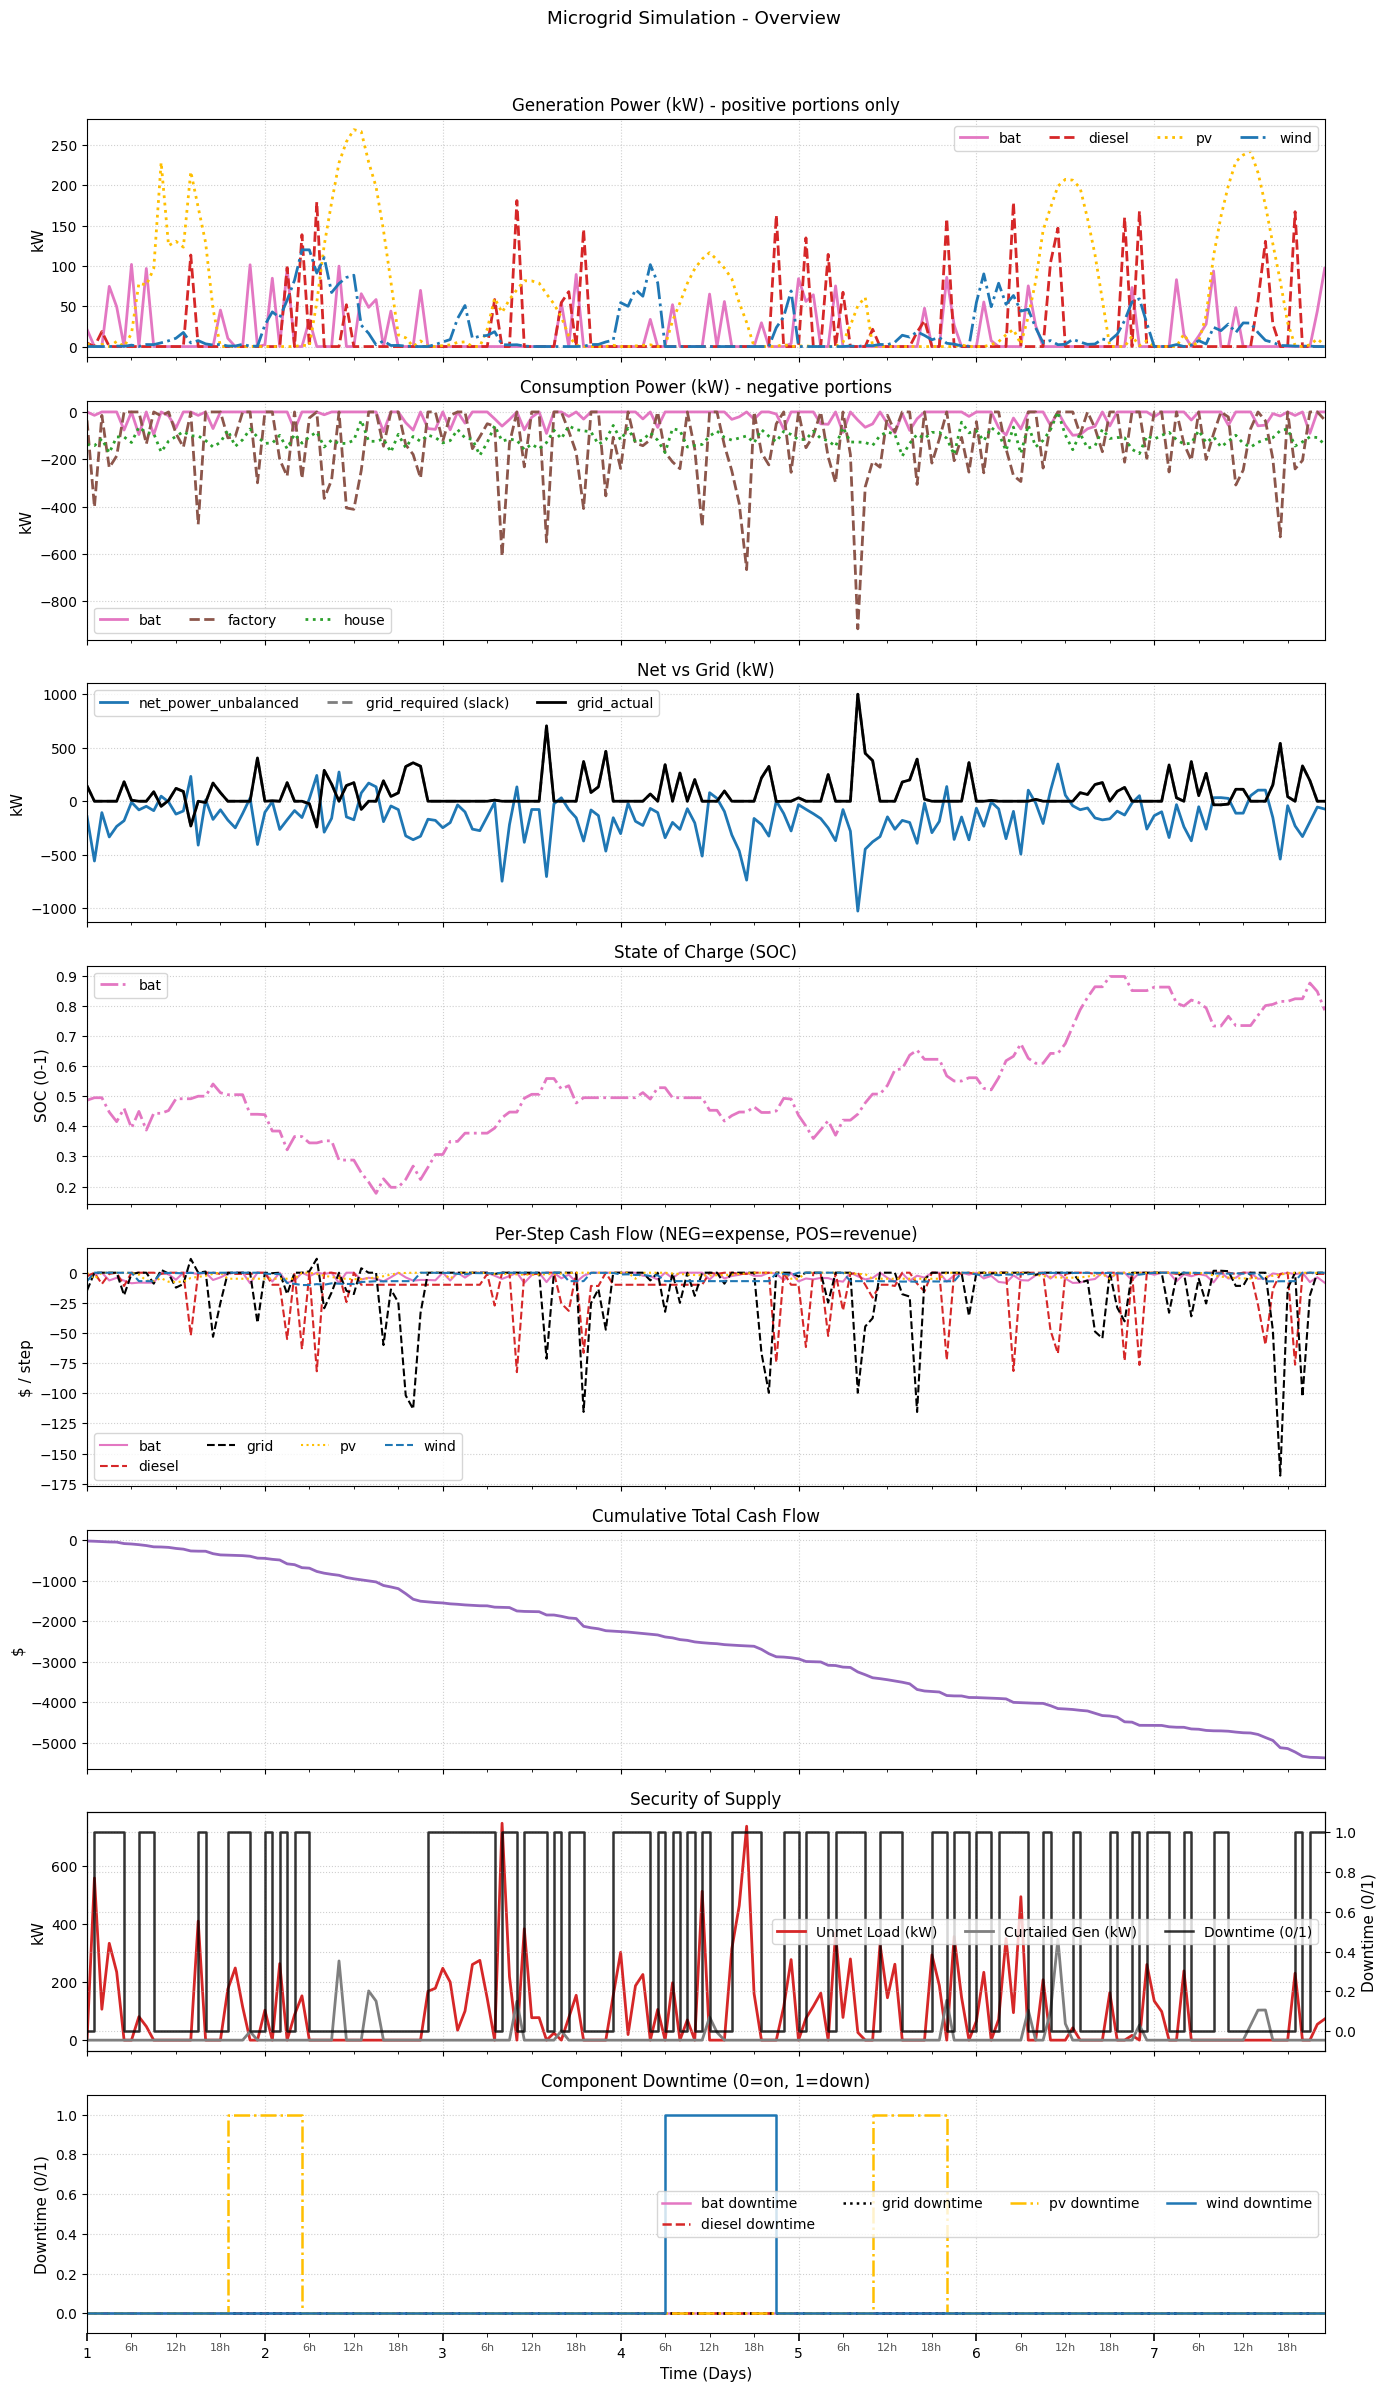

In [19]:
rand_env_test, _ = build_wrapped_env(seed=SEED, log_csv_path=os.path.join(LOG_DIR, "RANDOM_test_monitor.csv"))

obs, info = rand_env_test.reset(seed=SEED)
rand_reward = 0.0
done = False
rand_steps = 0
while not done:
    action = rand_env_test.action_space.sample()
    obs, reward, terminated, truncated, info = rand_env_test.step(action)
    rand_reward += reward
    rand_steps += 1
    done = terminated or truncated

df_random = rand_env_test.unwrapped.env.get_results(as_dataframe=True)
rand_metrics = summarize_results(df_random)

global_data["results"]["Random"] = {**rand_metrics, "Test Reward": rand_reward}

print("Random steps:", rand_steps)
print("Random reward:", f"{rand_reward:.2f}")
print("Random metrics:", rand_metrics)

_ = plot_simulation(
    df_random,
    sim_dt_minutes=SIM_DT,
    sim_name="06-RANDOM",
    save=True,
    base_dir=RESULTS_DIR
)


# Comparison of All Algorithms

In [20]:
def fmt_money(x): return f"${x:,.2f}"

comparison_df = pd.DataFrame(global_data["results"]).T
comparison_df["Total Cost ($)"] = comparison_df["Total Cost ($)"].apply(fmt_money)
comparison_df["Unmet Energy (kWh)"] = comparison_df["Unmet Energy (kWh)"].apply(lambda v: f"{v:.3f}")
comparison_df["Curtailed Energy (kWh)"] = comparison_df["Curtailed Energy (kWh)"].apply(lambda v: f"{v:.3f}")
comparison_df["Test Reward"] = comparison_df["Test Reward"].apply(lambda v: f"{v:.3f}")

print("\n" + "="*80)
print("🏁 ALGORITHM COMPARISON")
print("="*80)
print(comparison_df.to_string())
print("="*80)


🏁 ALGORITHM COMPARISON
       Total Cost ($) Unmet Energy (kWh) Curtailed Energy (kWh)  Test Reward
PPO        $-5,319.21              0.000                  0.000   -26596.033
A2C        $-7,469.94              0.000                  0.000   -37349.706
SAC        $-5,017.02              0.000                  0.000   -25085.116
TD3        $-5,212.88              0.000                  0.000   -26064.407
Random     $-5,365.85          15798.156               1935.051  -580054.978
